In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from synchrad.calc import SynchRad
from synchrad.utils import r_e, omega_1m, alpha_fs

from scipy.constants import e, m_e, c, epsilon_0, hbar
from scipy.integrate import solve_ivp

from tqdm.notebook import tqdm

# Example of the betatron radiation in an ion channel

## Defining undulator and particle parameter

In [2]:
Np = 4000        # Number of electrons
Num_osc = 4     # Number of oscillations
K0 = 20.0        # Undulator strength

# particles/beam central energy
particle_energy_MeV = 500

# Plasma density
n_p = 8e18 * 1e6

# Technical parameters : global

omega_1m = (2 * np.pi * c)
gamma_0 = particle_energy_MeV * 1e6 * e / (m_e * c**2)
pz0 = (gamma_0**2 - 1)**.5

gamma_0m = (1 + pz0**2 + K0**2)**.5

# Technical parameters: channel
omega_p = c * ( 4 * np.pi * r_e * n_p)**0.5 
omega_ch = omega_p / (2 * gamma_0m)**0.5
lambda_ch = 2 * np.pi * c / omega_ch
omega_ch_und = 2 * gamma_0**2 * omega_ch  / (1 + K0**2)
omega_ch_crit = 3/2 * K0 * gamma_0**2 * omega_ch

# Simulation length and steps
L_ch =  Num_osc * lambda_ch
T_fin  = L_ch / c
Nt = L_ch / lambda_ch * 64

t_eval = np.r_[0: T_fin: 1j * Nt]
dt = t_eval[1] - t_eval[0]

In [3]:
# Matched Beam

L_b = 1e-6
R_match = K0 * c/omega_p * (2/gamma_0)**0.5
energy_spread = 0.1

x = R_match/2**.5 * np.random.randn(Np)
y = R_match/2**.5 * np.random.randn(Np)
z = L_b * np.random.randn(Np)

ux = K0/2**.5 * np.random.randn(Np)
uy = K0/2**.5 * np.random.randn(Np)
uz = pz0 * (1 + energy_spread * np.random.randn(Np))

trak0 = np.array([x, y, z, ux, uy, uz])

In [4]:
def motion_channel(t, track, omega_p):
    x, y, z, ux, uy, uz = track
    
    gamma_p = np.sqrt(1.0 + ux**2 + uy**2 +  uz**2)
    
    dx = c * ux / gamma_p
    dy = c * uy / gamma_p
    dz = c * uz / gamma_p
    
    dux = - 0.5 * omega_p**2 / c * x
    duy = - 0.5 * omega_p**2 / c * y
    duz = 0.0
    
    return dx, dy, dz, dux, duy, duz

In [5]:
tracks = []

# coordinates and momenta tracks are staggered by a half time-step (leat-frog)
for ip in tqdm(range(Np)):
    
    x_, y_, z_, ux, uy, uz = solve_ivp( motion_channel, [0, T_fin], trak0[:, ip], 
                                        t_eval=t_eval, args=(omega_p,),
                                        method='Radau' ).y
    
    x, y, z, ux_, uy_, uz_ = solve_ivp( motion_channel, [0, T_fin+dt/2], trak0[:, ip], 
                                        t_eval=t_eval+dt/2, args=(omega_p,),
                                        method='Radau' ).y
    
    tracks.append([x, y, z, ux, uy, uz, 1.0, 0.0])

  0%|          | 0/4000 [00:00<?, ?it/s]

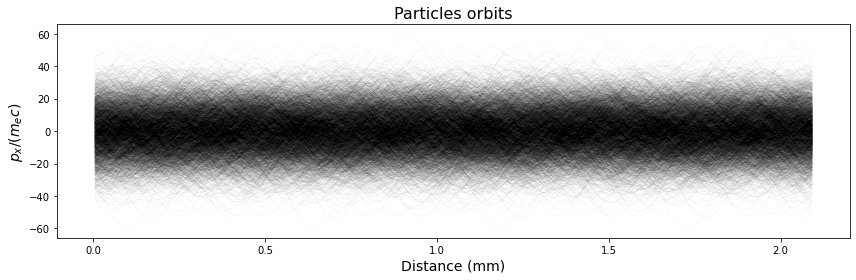

In [6]:
fig = plt.figure(figsize=(12,4), tight_layout=True)

for track in tracks:
    x, y, z, ux, uy, uz, w, id_start = track
    plt.plot(z*1e3, ux, c='k', lw=0.02)

plt.title('Particles orbits', fontsize=16)
plt.xlabel('Distance (mm)', fontsize=14)
plt.ylabel(r'$p_x / (m_e c)$', fontsize=14);

In [7]:
calc_input = {
    "grid": [
        (1e-3*omega_ch_crit/omega_1m, omega_ch_crit/omega_1m),  
        (0, 2*K0/gamma_0),
        (0.0, 2 * np.pi),
        (512, 32, 32),
    ],  
}

calc = SynchRad(calc_input)
calc.calculate_spectrum( particleTracks=tracks,
                         #comp='cartesian_complex',
                         #file_spectrum = './spect_coh.h5',
                         timeStep=c*dt )

  0%|          | 6/4000 [00:00<01:07, 59.28it/s]

Running on 1 devices
  ALL | GPU device: TITAN RTX
Platform: NVIDIA Corporation
Compiler: OpenCL C 1.2 
Separate it_range for each track will be used


100%|██████████| 4000/4000 [00:54<00:00, 72.78it/s]


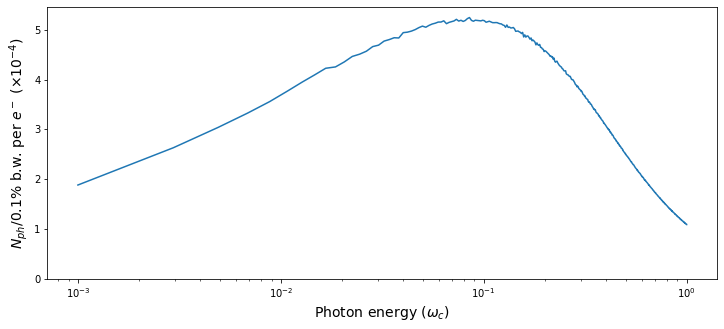

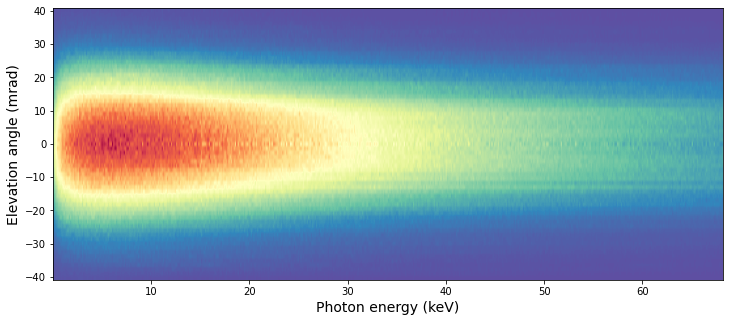

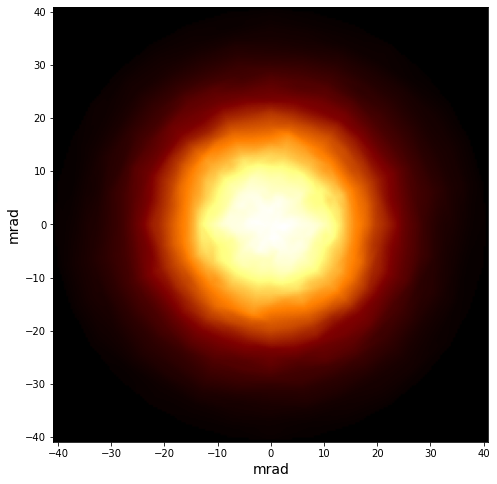

In [8]:
spect_val = calc.get_energy_spectrum(normalize_to_weights=True)
spect_val *= 1e-3
spect_ax_keV = calc.get_spectral_axis()  * 1.24e-6 * 1e-3
spect_ax_norm = calc.get_spectral_axis() * omega_1m/omega_ch_crit

plt.figure(figsize=(12,5))
plt.semilogx(spect_ax_norm, spect_val * 1e4 )
plt.xlabel(r'Photon energy ($\omega_c$)', fontsize=14)
plt.ylabel(r'$N_{ph}$/0.1% b.w. per $e^-$ ($\times 10^{-4}$)', fontsize=14)
plt.ylim(0,)

extent = [spect_ax_keV.min(), 
          spect_ax_keV.max(), 
          -calc.Args['theta'].max()* 1e3,
          calc.Args['theta'].max()* 1e3 ]

spect_val = calc.get_full_spectrum()
spect_val = np.c_[spect_val[:,:,spect_val.shape[2]//2-1][:,::-1], 
                  spect_val[:,1:,0]]

plt.figure(figsize=(12,5))
plt.imshow( spect_val.T,
            extent = extent,
            cmap=plt.cm.Spectral_r,
            origin='lower', 
           aspect='auto' )
plt.xlabel('Photon energy (keV)', fontsize=14)
plt.ylabel('Elevation angle (mrad)', fontsize=14);

plt.figure(figsize=(8,8))
spot, extent = calc.get_spot_cartesian(bins=(200, 200))
plt.imshow(spot.T, extent=extent*1e3, cmap=plt.cm.afmhot, )
[ lab('mrad', size=14) for lab in (plt.xlabel, plt.ylabel) ];